In [4]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *
import qiskit.quantum_info as qi

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

In [76]:
#To try out qiskits gradient optimizer we build a simple dataset with features and labels that offer binary classification
#We will use an example that resembles the behavior of an XOR
features = [[0,0],
            [0,1],
            [1,0],
            [1,1]]

targets = [0,
          1,
          1,
          0]

In [77]:
#We will then normalize to -1 and 1, as those are opposing rotations when using an RY-Gate
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    return MinMaxScaler().fit_transform(data) * 2 - 1

normalized_features = normalize_data(features)
print(normalized_features)

[[-1. -1.]
 [-1.  1.]
 [ 1. -1.]
 [ 1.  1.]]


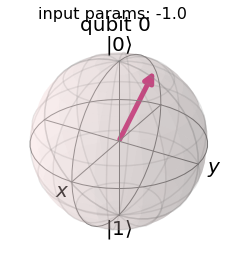

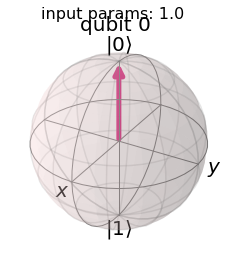

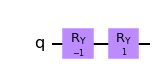

In [78]:
#If we add the parameters as is into the circuit, we get the following qubit states:
qc = QuantumCircuit(1)
for param in normalized_features[1]:
    qc.ry(param,0)
    state = Statevector.from_instruction(qc)
    display(plot_bloch_multivector(state, title="input params: " + str(param), reverse_bits=False))

qc.draw('mpl')

#As we can see, the rotation negate eachother and the qubit points again at |0>

In [79]:
#function to create the cost graph as well as fit and score the circuit on the given dataset

def fit_and_score(circuit_classifier, features, targets):
    plt.rcParams["figure.figsize"] = (12, 6)

    start_time = time.time()
    # fit classifier to data
    circuit_classifier.fit(features, targets)
    runtime = time.time() - start_time

    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # score classifier
    score =  circuit_classifier.score(features, targets)
    print('Score: ' + str(score))
    return score, runtime
    

In [81]:
# parity maps bitstrings to 0 or 1. As we have binary classification, we have 2 classes: 0 and 1
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return '{:b}'.format(x).count('1') % output_shape


In [28]:
# callback function that draws a live plot when the .fit() method is called

# saves the calculated weights
model_weights = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    model_weights.append(weights)

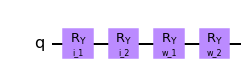

In [83]:

#build simulator that does 1024 shots per run, so per featureset calculates the result 1024 times
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

#construct QNN
#The feature map consists of 2 RY rotations that are parameterized to the 2 input features
feature_map = QuantumCircuit(1)
feature_map.ry(Parameter('i_1'),0)
feature_map.ry(Parameter('i_2'),0)

#The ansatz applies 2 weights
ansatz = QuantumCircuit(1)
ansatz.ry(Parameter('w_1'),0)
ansatz.ry(Parameter('w_2'),0)

qc = QuantumCircuit(1)
qc.append(feature_map, range(1))
qc.append(ansatz, range(1))
display(qc.decompose().draw('mpl'))

#The circuit was chosen arbitrarly, with the idea to build the simplest possible circuit

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

In [84]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

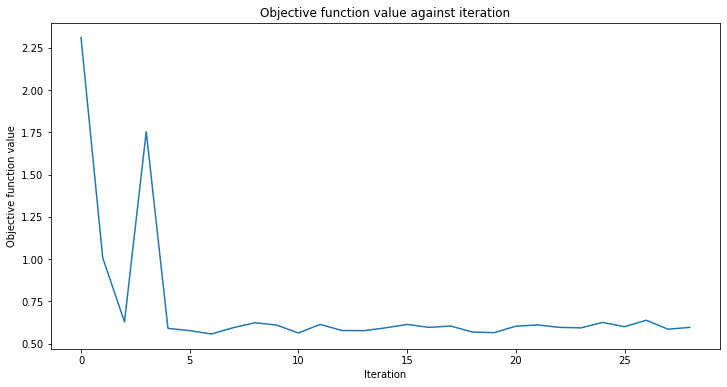

Score: 1.0


(1.0, 6.351282358169556)

In [85]:
#prepare the data
normalized_features = np.array(normalized_features)
targets = np.array(targets)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
fit_and_score(circuit_classifier, normalized_features, targets)


In [86]:
#As we can see we achieve perfect accuracy. 
#Apparently it seems to work, but what about a more complex dataset?
#One with 3 classes?
#For this we will use the IRIS dataset. Its been solved in a pletora of ways (SVM, NN etc.) so we have a good base to compare our results to

#Stats of the runtime for later comparison using plots
stats = []

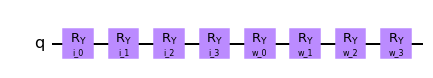

In [87]:
from sklearn.datasets import load_iris


#we need to update the parity function to resemble 3 classes
output_shape = 3  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return '{:b}'.format(x).count('1') % output_shape

# Load the data and split it up
dataset = load_iris()
data = dataset['data']
targets = np.array(dataset['target'])

#normalize data between [-1,1]
normalized_features = np.array(normalize_data(data))

#we extend the successfull circuit from the XOR dataset to support 4 features and 4 weights

feature_map = QuantumCircuit(1)
ansatz = QuantumCircuit(1)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),0)
    ansatz.ry(Parameter('w_' + str(i)),0)



qc = QuantumCircuit(1)
qc.append(feature_map, range(1))
qc.append(ansatz, range(1))
display(qc.decompose().draw('mpl'))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)



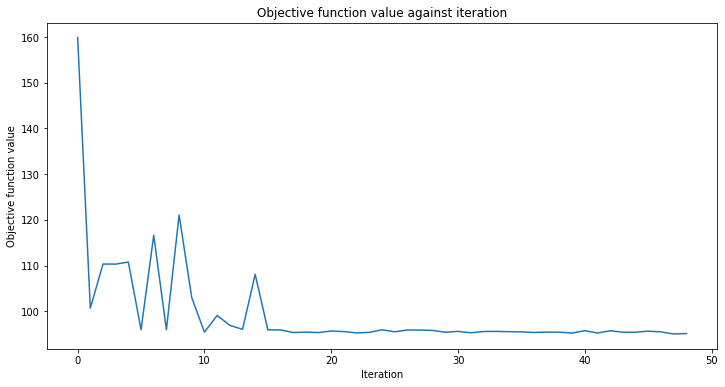

Score: 0.5466666666666666


In [88]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])

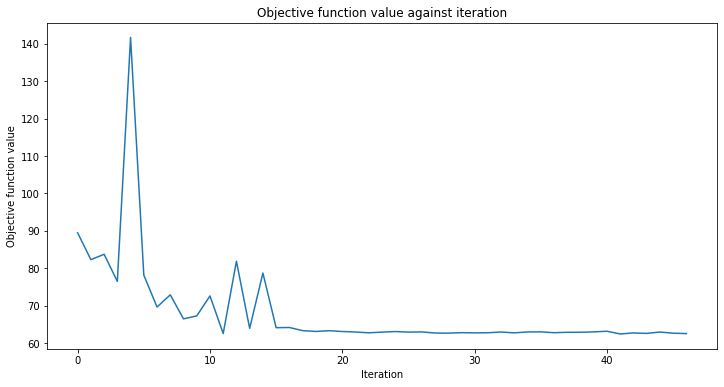

Score: 0.6933333333333334


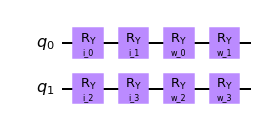

In [92]:
#okay, the accuracy is okay for a first try with 0.55. What if we increase the amount of qubits? In theory we then increase the possible statespace of the output
feature_map = QuantumCircuit(2)
ansatz = QuantumCircuit(2)
for i in range(int(len(normalized_features[1])/2)):
    feature_map.ry(Parameter('i_' + str(i)),0)
    feature_map.ry(Parameter('i_' + str(i+2)),1)
    ansatz.ry(Parameter('w_' + str(i)),0)
    ansatz.ry(Parameter('w_' + str(i+2)),1)



qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)




# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)  
complexity = qc.decompose().width() * qc.decompose().depth()
stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))

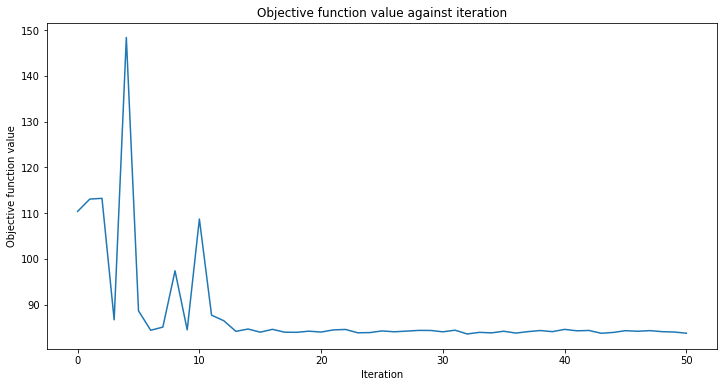

Score: 0.66


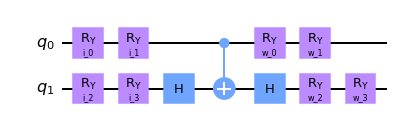

In [93]:
#Accuracy increase. What if we now add entanglement between the two qubits?
feature_map = QuantumCircuit(2)
ansatz = QuantumCircuit(2)
for i in range(int(len(normalized_features[1])/2)):
    feature_map.ry(Parameter('i_' + str(i)),0)
    feature_map.ry(Parameter('i_' + str(i+2)),1)
    ansatz.ry(Parameter('w_' + str(i)),0)
    ansatz.ry(Parameter('w_' + str(i+2)),1)



qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
#add entanglement using CZ-Gate. No specific reason, just experimenting
qc.cz(0,1)
qc.append(ansatz, range(2))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)




# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)  
complexity = qc.decompose().width() * qc.decompose().depth()
stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))

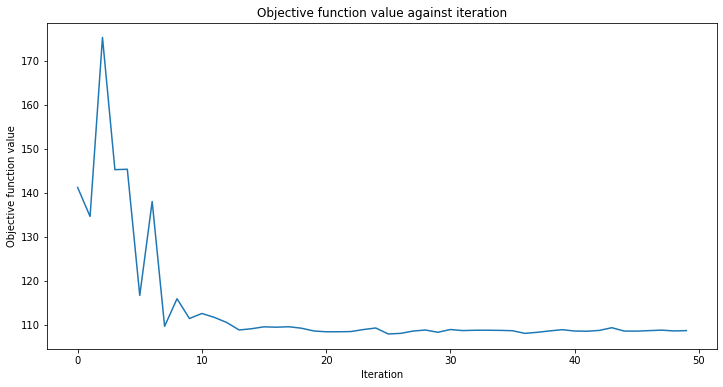

Score: 0.7733333333333333


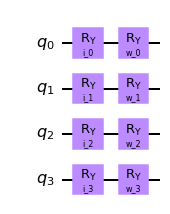

In [94]:
#The accuracy decreased. Maybe the circuit got too volatile to fit the weights to?
#Let's increase to 4 qubits with no entanglement
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)


objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)  
complexity = qc.decompose().width() * qc.decompose().depth()
stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))

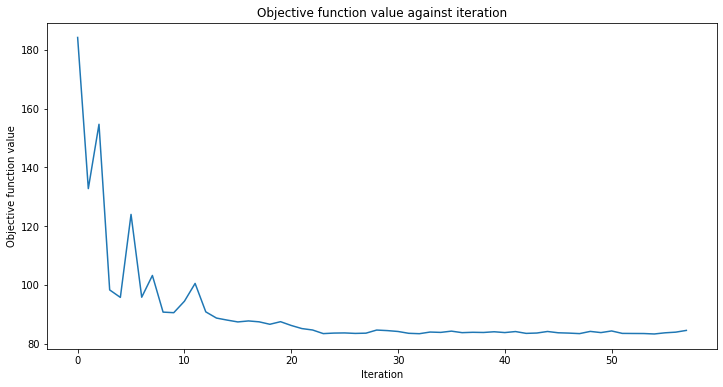

Score: 0.8466666666666667


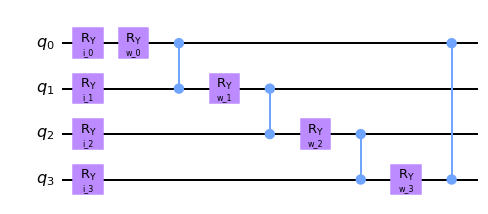

In [95]:
#Accuracy increase. What if we now add entanglement using CZ-Gates?

feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))

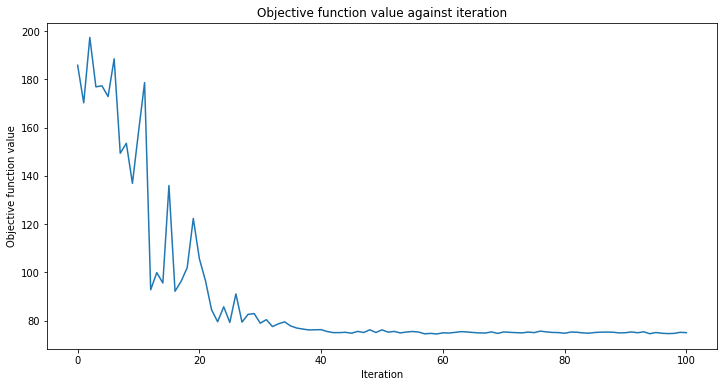

Score: 0.8933333333333333


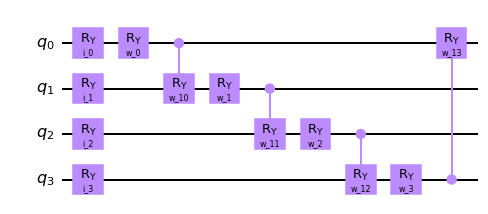

In [96]:
#Accuracy is better, but still nowhere to what we're used to with classical NNs What if we use CRY-Gates instead of CZ?
#This way the optimizer could adapt the weights to represent the weight each feature represents compared to other features

feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)



# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))

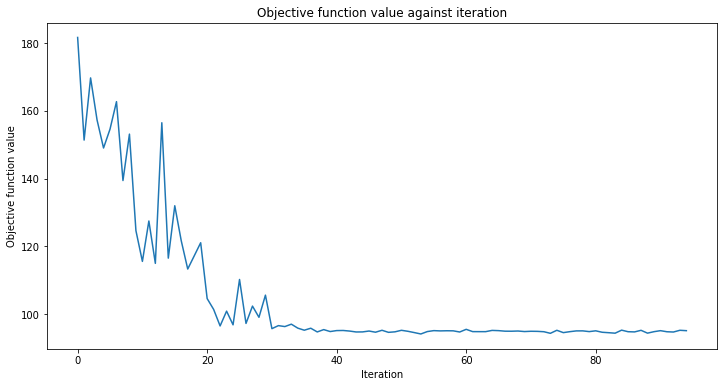

Score: 0.44666666666666666


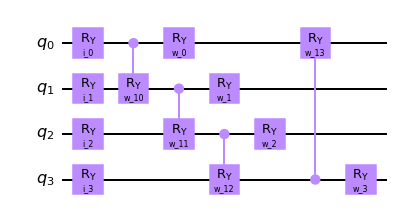

In [98]:
#What if we put the CRY before the RY?
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)
    ansatz.ry(Parameter('w_' + str(i)),i)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)


# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))

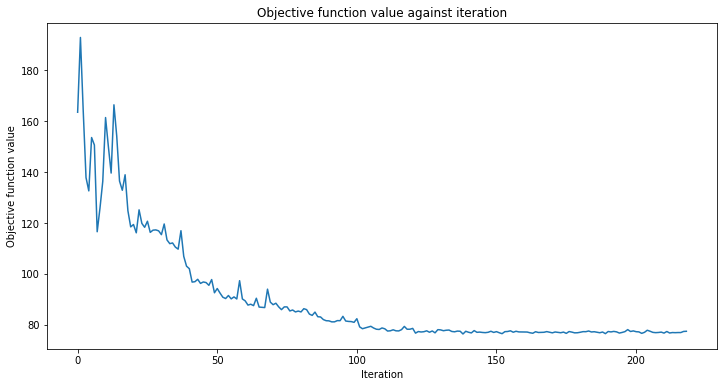

Score: 0.96


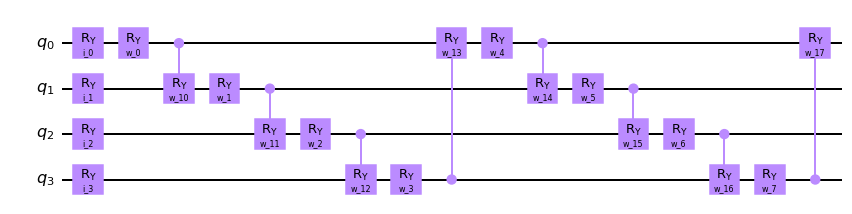

In [103]:
#As we can see applying the rotation beforehand results in a worse accuracy. 
#In QNN, there exists a concept called "RUS" - "Repeat until Success" where certain circuits are repeated n-times to increase the possible state space
#What if we take our succesfull circuit and repeat the ansatz twice?
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)

for i in range(len(normalized_features[1])):
    ansatz.ry(Parameter('w_' + str(i+4)),i)
    ansatz.cry(Parameter('w_' + str(10+i+4)), i, (i+1)%4)

qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)



# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))


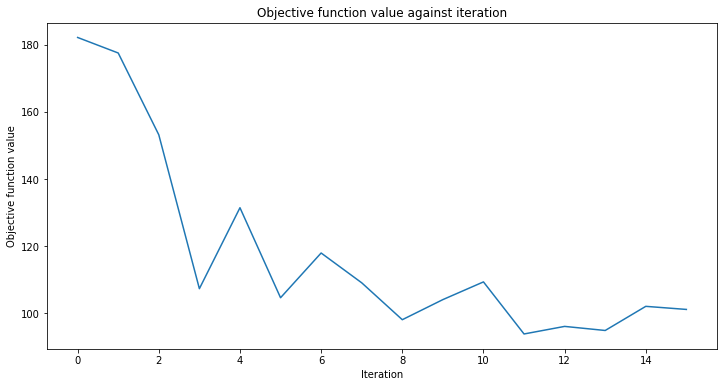

In [104]:
#another circuit that is often observed is encapsulating rotation gates with CZ gates. 
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)

for i in range(len(normalized_features[0])):
    ansatz.cz(i%4, (i+1)%4)
    ansatz.ry(Parameter('w_' + str(i)),(i+1)%4)
    ansatz.cz(i%4, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().draw('mpl'))

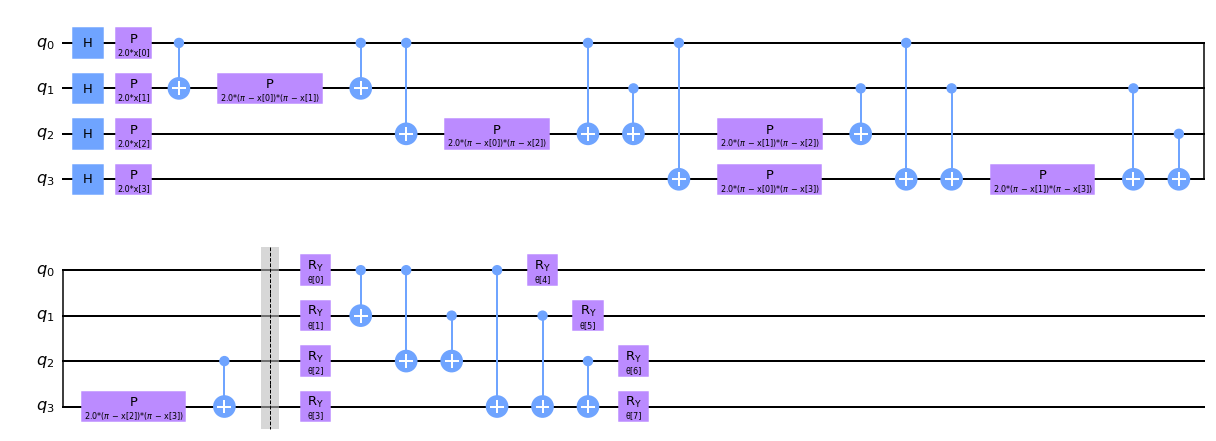

In [ ]:
#Let's now look at one of the common solutions qiskit offers
n_inputs = len(normalized_features[0])

# construct feature map
feature_map = ZZFeatureMap(n_inputs, reps=1)

# construct ansatz
ansatz = RealAmplitudes(n_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(n_inputs)
qc.append(feature_map, range(n_inputs))
qc.barrier()
qc.append(ansatz, range(n_inputs))

# construct QNN
circuit_qnn = CircuitQNN(circuit=qc,
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,
                                             optimizer=COBYLA(),
                                             callback=callback_graph)


# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().decompose().width() * qc.decompose().decompose().depth()

stats.append([runtime, score, complexity])
display(qc.decompose().decompose().draw('mpl'))


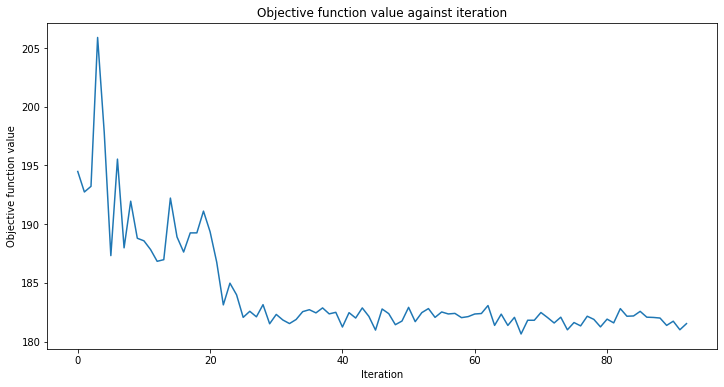

Score: 0.4533333333333333


In [ ]:
# construct QNN
circuit_qnn = CircuitQNN(circuit=qc,
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity]) 

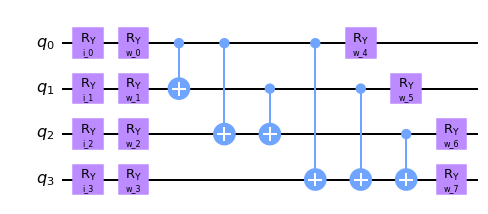

In [25]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)

for i in range(len(normalized_features[0])):
    ansatz.ry(Parameter('w_' + str(i)), i)

ansatz.cx(0,1)
ansatz.cx(0,2)
ansatz.cx(0,3)
ansatz.cx(1,2)
ansatz.cx(1,3)
ansatz.cx(2,3)

for i in range(len(normalized_features[0])):
    ansatz.ry(Parameter('w_' + str(i+4)), i)

qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))

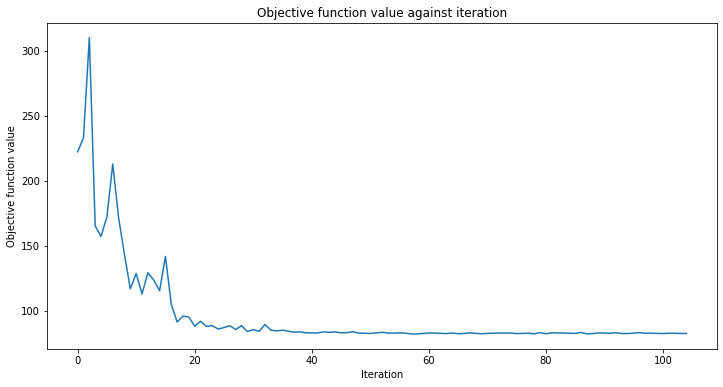

Score: 0.5866666666666667


In [26]:
#create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity])  

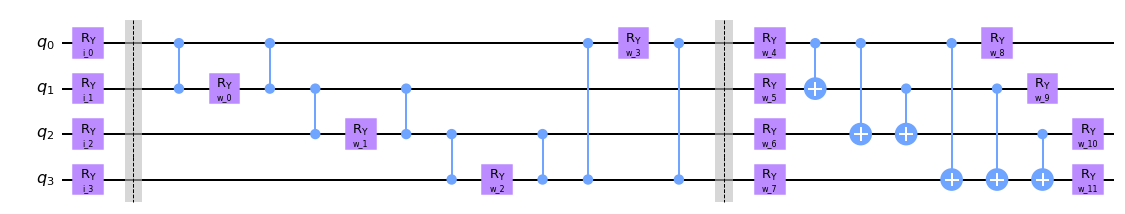

In [18]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)

for i in range(len(normalized_features[0])):
    ansatz.cz(i%4, (i+1)%4)
    ansatz.ry(Parameter('w_' + str(i)),(i+1)%4)
    ansatz.cz(i%4, (i+1)%4)

ansatz.barrier()

for i in range(len(normalized_features[0])):
    ansatz.ry(Parameter('w_' + str(i+4)), i)

ansatz.cx(0,1)
ansatz.cx(0,2)
ansatz.cx(0,3)
ansatz.cx(1,2)
ansatz.cx(1,3)
ansatz.cx(2,3)

for i in range(len(normalized_features[0])):
    ansatz.ry(Parameter('w_' + str(i+8)), i)

qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.barrier()
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)

display(qc.decompose().draw('mpl'))



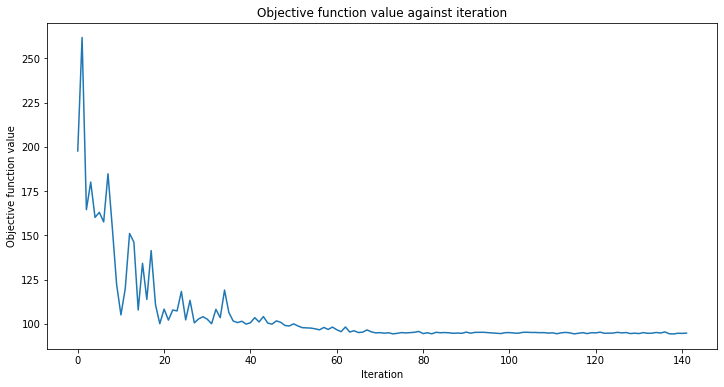

Score: 0.38


In [28]:
#create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().width() * qc.decompose().depth()

stats.append([runtime, score, complexity]) 

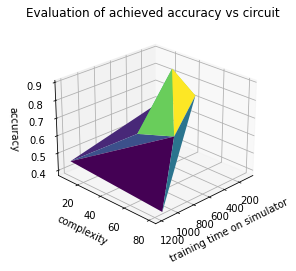

In [36]:
#Creating comparison of all circuits that use the full IRIS dataset:

stats = np.array(stats)

x, z, y = stats.reshape(-1,3).T

#z = np.array([[i] for i in z])

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_trisurf(x,y,z, cmap='viridis', linewidth=1)
ax.set_title('Evaluation of achieved accuracy vs circuit')
ax.set_xlabel('training time on simulator')
ax.set_ylabel('complexity')
ax.set_zlabel('accuracy')
ax.view_init(25, 45)

plt.show()


<BarContainer object of 7 artists>

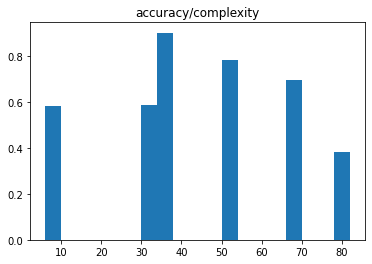

In [64]:
fig = plt.figure()
ax = plt.axes()
ax.set_title('accuracy/complexity')
ax.bar(y,z, width = 4)

<BarContainer object of 7 artists>

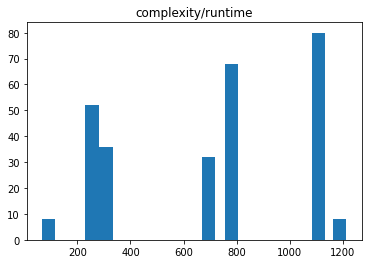

In [65]:
fig = plt.figure()
ax = plt.axes()
ax.set_title('complexity/runtime')
ax.bar(x,y, width = 50)

<BarContainer object of 7 artists>

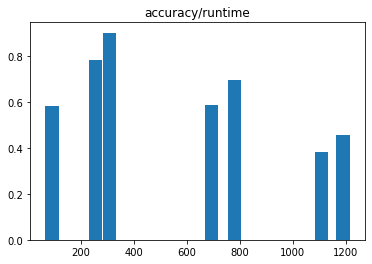

In [67]:
fig = plt.figure()
ax = plt.axes()
ax.set_title('accuracy/runtime')
ax.bar(x,z, width = 50)

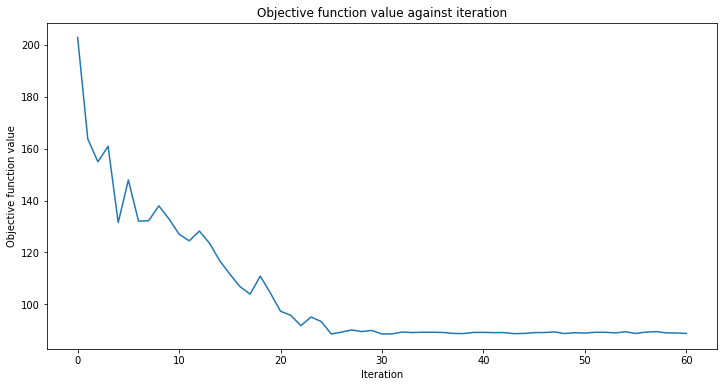

Score: 0.54


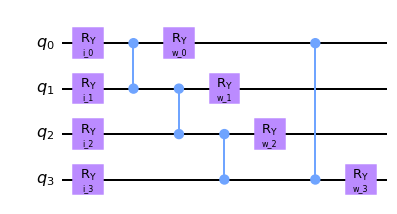

In [22]:

feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.cz(i%4, (i+1)%4)
    ansatz.ry(Parameter('w_' + str(i)), i)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))


circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph,
                                             warm_start=True)

#create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().decompose().width() * qc.decompose().decompose().depth()
display(qc.decompose().draw('mpl'))



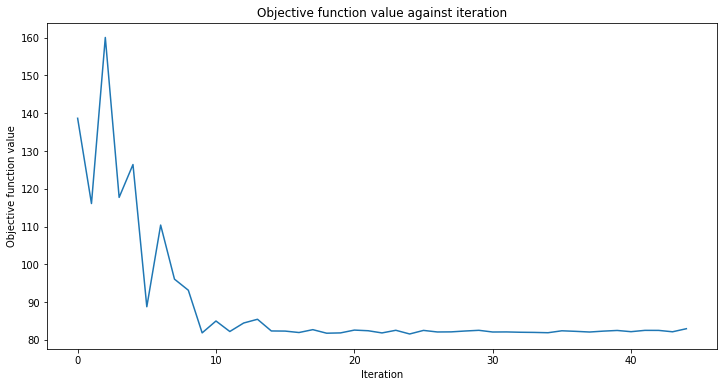

Score: 0.7133333333333334


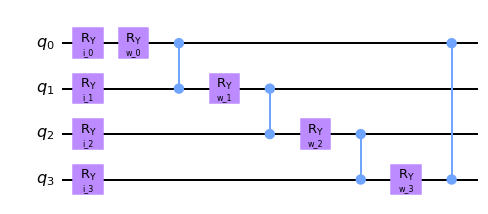

In [23]:

feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)), i)
    ansatz.cz(i%4, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))


circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph,
                                             warm_start=True)

#create empty array for callback to store evaluations of the objective function
objective_func_vals = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets)
complexity = qc.decompose().decompose().width() * qc.decompose().decompose().depth()
display(qc.decompose().draw('mpl'))